This notebook is based on the following notebook, thanks.

https://www.kaggle.com/manabendrarout/transformers-classifier-method-starter-train#Train-and-Validation-Functions

## libraries

In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore")
#general
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
import pickle
from tqdm.auto import tqdm
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import random
import gc
import cv2
gc.enable()
import glob
pd.set_option('display.max_columns', None) 
from sklearn.linear_model import RidgeCV

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# augmentation
from albumentations.pytorch import ToTensorV2
import albumentations as A

# deep learning
import timm
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR, CosineAnnealingLR, ReduceLROnPlateau, StepLR, LambdaLR
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imageio
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# metrics
from sklearn.metrics import mean_squared_error

In [2]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

## Config

In [3]:
class Config:
    base_dir = "/content/drive/MyDrive/petfinder"
    data_dir = "../input/petfinder-pawpularity-score/"
    meta_data_dir = "../input/trainmeta/"
    model_dir = "."
    output_dir = "."
    random_seed = 555
    n_epoch = 5
    n_fold = 5
    tta = 1 # 1 or 4
    model_path = "swin_large_patch4_window7_224"
    pretrained = True
    inp_channels = 3
    im_size =  224
    lr = 2e-5
    opt_wd_non_norm_bias = 0.01
    opt_wd_norm_bias = 0 # same as Adam in Fastai
    opt_beta1 = 0.9
    opt_beta2 = 0.99 # same as Adam in Fastai
    opt_eps = 1e-5 # same as Adam in Fastai
    batch_size = 32
    epoch_step_valid = 3
    num_workers = 8
    out_features = 1
    dropout = 0
    mixup = False
    mixup_alpha =1.0
    debug = False
    if debug:
        n_epoch = 1
        n_fold = 2
        n_sample_debug = 500

## set up environments & prepare data

- set_seed
Set random seed for random, torch, and numpy

https://docs.fast.ai/torch_core.html#set_seed

if reproducible is True:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def seed_everything(seed=Config.random_seed):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed%(2**32-1))
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False

seed_everything()
# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cuda


In [5]:
img_train_dir = os.path.join(Config.data_dir, 'train')
def return_imgfilepath(name, folder=img_train_dir):
    path = os.path.join(folder, f'{name}.jpg')
    return path

train_file_path = os.path.join(Config.data_dir, 'train.csv')
train_df = pd.read_csv(train_file_path)

# set image filepath
train_df['file_path'] = train_df['Id'].progress_apply(lambda x: return_imgfilepath(x))
train_df.head()

100%|██████████| 9912/9912 [00:00<00:00, 277124.51it/s]


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


## StratifiedKFold

<AxesSubplot:>

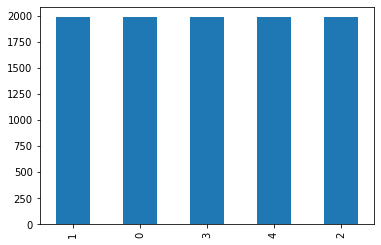

In [6]:
if Config.debug:
    train_df = train_df.sample(500).reset_index(drop = True)
train_df['norm_score'] = train_df['Pawpularity'] / 100
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['fold'] = -1

skf = StratifiedKFold(n_splits = Config.n_fold, shuffle=True, random_state =Config.random_seed)
for i, (_, train_index) in enumerate(skf.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [7]:
train_df[train_df['fold']==0].head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path,norm_score,bins,fold
5,001dd4f6fafb890610b1635f967ea081,0,0,1,0,0,0,0,0,0,0,0,1,74,../input/petfinder-pawpularity-score/train/001...,0.74,32,0
13,006483b96ca9c09b7afed3e3d3af539d,0,1,1,1,0,0,0,0,1,1,0,0,41,../input/petfinder-pawpularity-score/train/006...,0.41,17,0
29,00b151a572c9aabedf8cfce0fa18be25,0,0,1,1,0,0,0,0,0,0,0,1,21,../input/petfinder-pawpularity-score/train/00b...,0.21,8,0
46,0126fe11deba78f84fd05cd5f12c5a4b,0,1,1,1,0,0,0,0,0,0,0,0,37,../input/petfinder-pawpularity-score/train/012...,0.37,15,0
52,01430d6ae02e79774b651175edd40842,0,1,1,1,0,0,0,1,0,0,1,0,28,../input/petfinder-pawpularity-score/train/014...,0.28,11,0


## Dataset & augmentation

### PetDataset
channels of image converted to 0-1

### get_transforms
Only resizing is applied to both train and valid data 

In [8]:
class PetDataset(Dataset):
    def __init__(self, image_filepaths, targets, transform=None):
        self.image_filepaths = image_filepaths
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.image_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.image_filepaths[idx]
        with open(image_filepath, 'rb') as f:
            image = Image.open(f)
            image_rgb = image.convert('RGB')
        image = np.array(image_rgb) / 255 # convert to 0-1

        if self.transform is not None:
            image = self.transform(image = image)["image"]
        
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        target = self.targets[idx]

        image = torch.tensor(image, dtype = torch.float)
        target = torch.tensor(target, dtype = torch.float)
        return image, target
    
def get_transforms(dim = Config.im_size):
    return A.Compose(
        [            
            A.Resize(height=dim, width=dim)
        ]
    )

## model

In [9]:
class PetNet(nn.Module):
    def __init__(
        self,
        model_name = Config.model_path,
        out_features = Config.out_features,
        inp_channels=Config.inp_channels,
        pretrained=Config.pretrained
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=inp_channels, num_classes = out_features)
    
    def forward(self, image):
        output = self.model(image)
        return output

## helper function

### divice_norm_bias
function to divide parameters at BatchNorm layer and all bias or not.

### usr_rmse_score
calculate competition metrics

reference
- https://docs.fast.ai/learner.html#Learner
- https://docs.fast.ai/optimizer.html#Adam
- https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
- https://docs.fast.ai/losses.html#BCEWithLogitsLossFlat


In [10]:
def divice_norm_bias(model): 
    norm_bias_params = []
    non_norm_bias_params = []
    except_wd_layers = ['norm', '.bias']
    for n, p in model.model.named_parameters():
        if any([nd in n for nd in except_wd_layers]):
            norm_bias_params.append(p)
        else:
            non_norm_bias_params.append(p)
    return norm_bias_params, non_norm_bias_params

def usr_rmse_score(output, target):
    y_pred = torch.sigmoid(output).cpu()
    y_pred = y_pred.detach().numpy()*100
    target = target.cpu()*100
    
    return mean_squared_error(target, y_pred, squared=False)

def rmse_oof(_oof_df, fold=None):
    oof_df = _oof_df.copy()
    if fold is not None:
        oof_df = oof_df[oof_df["fold"] == fold]
    target = oof_df['Pawpularity'].values
    y_pred = oof_df['pred'].values
    if fold is not None:
        print(f'fold {fold}: {mean_squared_error(target, y_pred, squared=False)}')
    else:
        print(f'overall: {mean_squared_error(target, y_pred, squared=False)}')

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
    


In [11]:
def train_fn(train_loader, model, criterion, optimizer, epoch):
    metric_monitor = MetricMonitor()
    model.train()
    scaler = GradScaler()
    stream = tqdm(train_loader)

    for batch_idx, (images, target) in enumerate(stream, start = 1):
        images = images.to(device, non_blocking = True).float()
        target = target.to(device, non_blocking = True).float().view(-1, 1)


        with autocast(): # mixed precision
            output = model(images)
        
        loss = criterion(output, target)
        rmse_score = usr_rmse_score(output, target)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('RMSE', rmse_score)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        stream.set_description(f'Epoch: {epoch:02}. Train. {metric_monitor}')

def valid_fn(valid_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(valid_loader)
    final_targets = []
    final_preds = []
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(device, non_blocking = True).float()
        target = target.to(device, non_blocking = True).float().view(-1, 1)
        with torch.no_grad():
            output = model(images)
        
        loss = criterion(output, target)
        rmse_score = usr_rmse_score(output, target)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('RMSE', rmse_score)
        stream.set_description(f"Epoch: {epoch:02}. Valid. {metric_monitor}")
        target = (target.detach().cpu().numpy() * 100).ravel().tolist()
        pred = (torch.sigmoid(output).detach().cpu().numpy() * 100).ravel().tolist()

        final_preds.extend(pred)
        final_targets.extend(target)
    final_preds = np.array(final_preds)
    final_targets = np.array(final_targets)
    del valid_loader, target, output, images
    gc.collect()
    torch.cuda.empty_cache()
    return final_targets, final_preds

## training loop

- scheduler: none
- optimizer: AdamW
hyper parameters are the same as Adam in Fastai

In [12]:
oof_df = pd.DataFrame()
for fold in range(Config.n_fold):
    print(f'=== fold {fold}: training ===')
    train = train_df[train_df['fold'] != fold]
    valid = train_df[train_df['fold'] == fold]
    valid_idx = valid.index
    
    X_train_paths = train['file_path'].values
    y_train = train['norm_score'].values
    X_valid_paths = valid['file_path'].values
    y_valid = valid['norm_score'].values
    
    train_dataset = PetDataset(
      image_filepaths = X_train_paths,
      targets = y_train,
      transform = get_transforms()
    )
    
    train_loader = DataLoader(
      train_dataset,
      batch_size = Config.batch_size,
      shuffle = True,
      num_workers = Config.num_workers,
      pin_memory = True
    )
    
    valid_dataset = PetDataset(
      image_filepaths = X_valid_paths,
      targets = y_valid,
      transform = get_transforms()
    )
    
    valid_loader = DataLoader(
      valid_dataset,
      batch_size = Config.batch_size,
      shuffle = True,
      num_workers = Config.num_workers,
      pin_memory = True
    )
    
    model = PetNet()
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    norm_bias_params, non_norm_bias_params = divice_norm_bias(model)
    optimizer = torch.optim.AdamW(
      [
          {'params': norm_bias_params, 'weight_decay': Config.opt_wd_norm_bias},
          {'params': non_norm_bias_params, 'weight_decay': Config.opt_wd_non_norm_bias},
      ],
      betas=(Config.opt_beta1, Config.opt_beta2),
      eps=Config.opt_eps,
      lr = Config.lr,
      amsgrad = False
    )
    
    best_rmse = np.inf
    for epoch in range(1, Config.n_epoch + 1):
        print(f'=== fold:{fold} epoch: {epoch}: training ===')
        train_fn(train_loader, model, criterion, optimizer, epoch)
        valid_targets, preds = valid_fn(valid_loader, model, criterion, epoch)
        valid_rmse = round(mean_squared_error(valid_targets, preds, squared=False), 3)
        print(f'epoch {epoch}: rmse: {valid_rmse}')
        
        if valid_rmse < best_rmse:
            best_rmse = valid_rmse
            torch.save(model.state_dict(), f'{Config.model_dir}/model_fold{fold}.pth')
            print("saved model.")
            _oof_df = pd.DataFrame(data={'Pawpularity':valid_targets, 'pred':preds, 'fold':fold}, index=valid_idx)
            
    del model, train_dataset, train_loader, valid_dataset, valid_loader
    gc.collect()
    torch.cuda.empty_cache()
    oof_df = pd.concat([oof_df, _oof_df])

=== fold 0: training ===
=== fold:0 epoch: 1: training ===


Epoch: 01. Train. Loss: 0.650 | RMSE: 18.609: 100%|██████████| 248/248 [06:02<00:00,  1.46s/it]
Epoch: 01. Valid. Loss: 0.644 | RMSE: 17.825: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


epoch 1: rmse: 18.013
saved model.
=== fold:0 epoch: 2: training ===


Epoch: 02. Train. Loss: 0.635 | RMSE: 16.660: 100%|██████████| 248/248 [05:54<00:00,  1.43s/it]
Epoch: 02. Valid. Loss: 0.642 | RMSE: 17.533: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


epoch 2: rmse: 17.834
saved model.
=== fold:0 epoch: 3: training ===


Epoch: 03. Train. Loss: 0.623 | RMSE: 14.867: 100%|██████████| 248/248 [05:55<00:00,  1.43s/it]
Epoch: 03. Valid. Loss: 0.645 | RMSE: 17.898: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


epoch 3: rmse: 18.164
=== fold:0 epoch: 4: training ===


Epoch: 04. Train. Loss: 0.610 | RMSE: 12.851: 100%|██████████| 248/248 [05:56<00:00,  1.44s/it]
Epoch: 04. Valid. Loss: 0.649 | RMSE: 18.234: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


epoch 4: rmse: 18.538
=== fold:0 epoch: 5: training ===


Epoch: 05. Train. Loss: 0.598 | RMSE: 10.867: 100%|██████████| 248/248 [05:54<00:00,  1.43s/it]
Epoch: 05. Valid. Loss: 0.652 | RMSE: 18.628: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]


epoch 5: rmse: 18.875
=== fold 1: training ===
=== fold:1 epoch: 1: training ===


Epoch: 01. Train. Loss: 0.651 | RMSE: 18.729: 100%|██████████| 248/248 [05:55<00:00,  1.43s/it]
Epoch: 01. Valid. Loss: 0.644 | RMSE: 17.918: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


epoch 1: rmse: 18.091
saved model.
=== fold:1 epoch: 2: training ===


Epoch: 02. Train. Loss: 0.636 | RMSE: 16.782: 100%|██████████| 248/248 [05:56<00:00,  1.44s/it]
Epoch: 02. Valid. Loss: 0.646 | RMSE: 18.066: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


epoch 2: rmse: 18.312
=== fold:1 epoch: 3: training ===


Epoch: 03. Train. Loss: 0.625 | RMSE: 15.205: 100%|██████████| 248/248 [05:56<00:00,  1.44s/it]
Epoch: 03. Valid. Loss: 0.649 | RMSE: 18.305: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


epoch 3: rmse: 18.564
=== fold:1 epoch: 4: training ===


Epoch: 04. Train. Loss: 0.614 | RMSE: 13.484: 100%|██████████| 248/248 [05:56<00:00,  1.44s/it]
Epoch: 04. Valid. Loss: 0.648 | RMSE: 18.240: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


epoch 4: rmse: 18.518
=== fold:1 epoch: 5: training ===


Epoch: 05. Train. Loss: 0.602 | RMSE: 11.484: 100%|██████████| 248/248 [05:56<00:00,  1.44s/it]
Epoch: 05. Valid. Loss: 0.660 | RMSE: 19.442: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


epoch 5: rmse: 19.678
=== fold 2: training ===
=== fold:2 epoch: 1: training ===


Epoch: 01. Train. Loss: 0.650 | RMSE: 18.618: 100%|██████████| 248/248 [05:56<00:00,  1.44s/it]
Epoch: 01. Valid. Loss: 0.641 | RMSE: 17.459: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


epoch 1: rmse: 17.729
saved model.
=== fold:2 epoch: 2: training ===


Epoch: 02. Train. Loss: 0.636 | RMSE: 16.825: 100%|██████████| 248/248 [05:57<00:00,  1.44s/it]
Epoch: 02. Valid. Loss: 0.642 | RMSE: 17.600: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


epoch 2: rmse: 17.864
=== fold:2 epoch: 3: training ===


Epoch: 03. Train. Loss: 0.624 | RMSE: 15.031: 100%|██████████| 248/248 [05:57<00:00,  1.44s/it]
Epoch: 03. Valid. Loss: 0.643 | RMSE: 17.654: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


epoch 3: rmse: 17.894
=== fold:2 epoch: 4: training ===


Epoch: 04. Train. Loss: 0.610 | RMSE: 12.938: 100%|██████████| 248/248 [05:57<00:00,  1.44s/it]
Epoch: 04. Valid. Loss: 0.645 | RMSE: 17.954: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


epoch 4: rmse: 18.21
=== fold:2 epoch: 5: training ===


Epoch: 05. Train. Loss: 0.598 | RMSE: 10.901: 100%|██████████| 248/248 [05:57<00:00,  1.44s/it]
Epoch: 05. Valid. Loss: 0.649 | RMSE: 18.292: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


epoch 5: rmse: 18.644
=== fold 3: training ===
=== fold:3 epoch: 1: training ===


Epoch: 01. Train. Loss: 0.651 | RMSE: 18.673: 100%|██████████| 248/248 [05:57<00:00,  1.44s/it]
Epoch: 01. Valid. Loss: 0.644 | RMSE: 17.802: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


epoch 1: rmse: 18.074
saved model.
=== fold:3 epoch: 2: training ===


Epoch: 02. Train. Loss: 0.636 | RMSE: 16.756: 100%|██████████| 248/248 [05:58<00:00,  1.44s/it]
Epoch: 02. Valid. Loss: 0.641 | RMSE: 17.424: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


epoch 2: rmse: 17.683
saved model.
=== fold:3 epoch: 3: training ===


Epoch: 03. Train. Loss: 0.624 | RMSE: 15.023: 100%|██████████| 248/248 [05:57<00:00,  1.44s/it]
Epoch: 03. Valid. Loss: 0.643 | RMSE: 17.556: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


epoch 3: rmse: 17.831
=== fold:3 epoch: 4: training ===


Epoch: 04. Train. Loss: 0.610 | RMSE: 12.935: 100%|██████████| 248/248 [05:57<00:00,  1.44s/it]
Epoch: 04. Valid. Loss: 0.647 | RMSE: 18.086: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]


epoch 4: rmse: 18.392
=== fold:3 epoch: 5: training ===


Epoch: 05. Train. Loss: 0.598 | RMSE: 10.844: 100%|██████████| 248/248 [05:56<00:00,  1.44s/it]
Epoch: 05. Valid. Loss: 0.648 | RMSE: 18.235: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


epoch 5: rmse: 18.482
=== fold 4: training ===
=== fold:4 epoch: 1: training ===


Epoch: 01. Train. Loss: 0.653 | RMSE: 18.974: 100%|██████████| 248/248 [05:56<00:00,  1.44s/it]
Epoch: 01. Valid. Loss: 0.645 | RMSE: 17.873: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


epoch 1: rmse: 18.17
saved model.
=== fold:4 epoch: 2: training ===


Epoch: 02. Train. Loss: 0.637 | RMSE: 17.013: 100%|██████████| 248/248 [05:57<00:00,  1.44s/it]
Epoch: 02. Valid. Loss: 0.642 | RMSE: 17.403: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]


epoch 2: rmse: 17.722
saved model.
=== fold:4 epoch: 3: training ===


Epoch: 03. Train. Loss: 0.625 | RMSE: 15.245: 100%|██████████| 248/248 [05:57<00:00,  1.44s/it]
Epoch: 03. Valid. Loss: 0.642 | RMSE: 17.634: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


epoch 3: rmse: 17.851
=== fold:4 epoch: 4: training ===


Epoch: 04. Train. Loss: 0.613 | RMSE: 13.362: 100%|██████████| 248/248 [05:57<00:00,  1.44s/it]
Epoch: 04. Valid. Loss: 0.644 | RMSE: 17.706: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


epoch 4: rmse: 18.037
=== fold:4 epoch: 5: training ===


Epoch: 05. Train. Loss: 0.601 | RMSE: 11.268: 100%|██████████| 248/248 [05:56<00:00,  1.44s/it]
Epoch: 05. Valid. Loss: 0.647 | RMSE: 18.062: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


epoch 5: rmse: 18.278


## cv score

In [13]:
for i in range(Config.n_fold):
    rmse_oof(oof_df, i)
rmse_oof(oof_df)

fold 0: 17.834249750110402
fold 1: 18.091371956797317
fold 2: 17.72881102092657
fold 3: 17.683328549228985
fold 4: 17.722125081170105
overall: 17.812625904243372


In [14]:
oof_df.sort_index().to_csv('oof.csv', index=False)

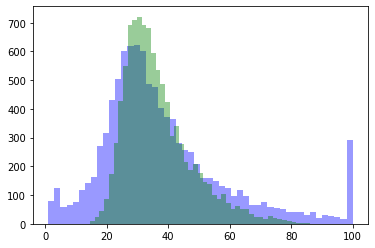

In [15]:
plt.hist(oof_df['Pawpularity'].values, alpha = 0.4, color = 'b', label = 'target', bins = 50)
plt.hist(oof_df['pred'].values, alpha = 0.4, color = 'g', label = 'prediction', bins = 50)
plt.show()